In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Global Variables
timeout = 500 * 1000
delta_threshold = 0.1

In [4]:
def density_xor(d):
    reward = lambda x, y: x ^ y if (x + y) % 10 < d else np.random.uniform(-1, 0)
    return reward

class Grid: 
    def __init__(self, edge_len, start = (0,0), actions = lambda x: [ 'l', 'd', 'u', 'r' ], reward_func = density_xor(5) ):
        self.edge = edge_len
        self.actions = actions
        self.start = start
        self.reward_func = reward_func
        
    def transition(self, state, action):
        x, y = state

        if action == "u":
            state = ( (x + 1) % self.edge, y )
        elif action == "d":
            state = ( (x - 1) % self.edge, y )
        elif action == "l":
            state = ( x, (y + 1) % self.edge )
        elif action == "r":
            state = ( x, (y - 1) % self.edge )

        return self.reward_func(* state), state

In [ ]:

"""
        if x == 0:
            reward = 1
        elif x == 14 and (y == 13 or y == 14):
            reward = 100
        else:
            reward = 1 / (abs(x - 14) + abs(y - 13)) / 5
        
        # class MarkovGrid(Grid):
    def __init__(self, edge_len, pi, actions = lambda x: [ 0, 1 ]):
        super().__init__(edge_len)
        self.markov_state = 0
        self.pi = pi
        self.actions = actions
        
    def transition(self, state, action):
        reward = (self.markov_state ^ action) * np.random.uniform(-2, 2)
        self.markov_state = 0 if np.random.random() < self.pi[self.markov_state, 0] else 1
        return reward, state

    def initialize_q(self, grid):
        self.q_vals = {}
        for state in [ (i, j) for i in range(grid.edge) for j in range(grid.edge) ]:
            for action in grid.actions(state):
                self.q_vals[( state, action )] = 0.0
        return grid
"""

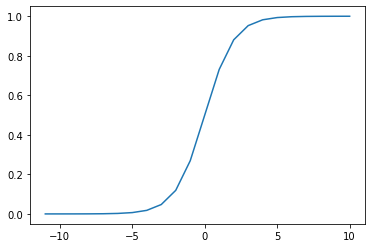

In [5]:
# Editorial Note: low rho make slow
def sigmoid(x, rho = 1):
    return (np.exp(rho * x) / (1 + np.exp(rho * x)))

plt.plot( range(-11, 11), [ sigmoid(i) for i in range(-11, 11) ] )
plt.show()

In [6]:
from collections import defaultdict

class agent: 
    def __init__( self, alpha = 0.1, epsilon = 0.5, discount = 0.1, rhos = (1, 1), lags = -1 ) -> None:
        self.q_vals, self.v_vals = defaultdict(lambda: 0), defaultdict(lambda: 0)
        self.alpha, self.epsilon, self.discount = alpha, epsilon, discount
        self.rho1, self.rho2 = rhos

        self.TDES, self.L = [0], lags
 
    def update(self, state, next_state, action, reward) -> float: 
        max_qval = max([ self.q_vals[(next_state, a)] for a in self.grid.actions(next_state) ])
        previous = self.q_vals[(state, action)]
        
        self.q_vals[(state, action)] = (1 - self.alpha) * previous + self.alpha * (reward + self.discount * (max_qval))
        self.v_vals[state] = self.v_vals[state] + 1
        
        delta = abs( self.q_vals[(state, action)] - previous )
        self.TDES.append(delta)
        
        if self.L > -1 and len(self.TDES) > self.L:
            self.TDES.pop(0)
        return delta
        
    def epsilon_greedy(self, state) -> str:
        max_action = max(self.grid.actions(state), key = lambda x: self.q_vals[(state, x)])
        return max_action if np.random.random() < self.epsilon else np.random.choice( self.grid.actions(state) )
        
    def softmax(self, state, beta = 1) -> str:
        q_vals = np.array( [ self.q_vals[(state, a)] for a in self.grid.actions(state) ])
        softmax = np.exp((q_vals * beta)) / (np.sum(np.exp(q_vals * beta)))
        return np.random.choice( self.grid.actions(state), p = softmax )
    
    def boltzmann(self, state) -> str:
        return self.softmax(state, beta = self.epsilon)
    
    def mixture(self, state, epsilon = None) -> str:
        epsilon = epsilon or self.epsilon
        return self.softmax(state) if np.random.random() < epsilon else np.random.choice( self.grid.actions(state) )
    
    def phi_explore(self, state):
        state_len = len(self.q_vals) + 1
        state_sum = np.sum([ self.v_vals[i] for i in self.v_vals ]) + 1
        return sigmoid((1 / state_len) - ( self.v_vals[state] / state_sum ), self.rho1)
    
    def phi_exploit(self, state):
        relative = self.TDES[-1] / np.sum(self.TDES)
        return sigmoid(1 - (relative * len(self.TDES)), self.rho2)

    def inhomogeniety(self, state):
        epsilon = self.phi_exploit(state)
        return epsilon / (epsilon + self.phi_explore(state))
        
    def inhomogenous_greedy(self, state) -> str:
        max_action = max(self.grid.actions(state), key = lambda x: self.q_vals[(state, x)])
        return max_action if np.random.random() < self.inhomogeniety(state) else np.random.choice( self.grid.actions(state) )
        
    def inhomogenous_boltzmann(self, state) -> str:
        return self.softmax(state, beta = self.inhomogeniety(state))
    
    def inhomogenous_mixture(self, state) -> str:
        return self.softmax(state) if np.random.random() < self.inhomogeniety(state) else np.random.choice( self.grid.actions(state) )
        
    def play(self, grid, action_selection, limit):  
        converge, i, state = 0, 0, grid.start
        self.grid = grid
        
        while (converge < limit) and (i < timeout):
            action = action_selection(self, state)
            reward, next_state = self.grid.transition(state, action)

            delta = self.update(state, next_state, action, reward)
            converge = converge + 1
            if delta > delta_threshold:
                converge = 0
            
            state, i = next_state, i + 1
            self.alpha = self.alpha * 0.9995
        
        average_reward, self.epsilon = 0, 0.9
        for p in range(limit // 2):
            action = self.epsilon_greedy(state)
            reward, state = self.grid.transition(state, action)     
            average_reward = average_reward + reward
        
        return i, (2 / limit) * average_reward
    
    def reset(self):
        self.q_vals, self.v_vals = defaultdict(lambda: 0), defaultdict(lambda: 0)

In [ ]:
grid = Grid(50) # MarkovGrid( 1, np.array([0.5, 0.5, 0.5, 0.5]).reshape((2, 2)) )

In [ ]:
_agent = agent()
_agent.play( grid, agent.inhomogenous_greedy, 100 )

In [7]:
import gc

def select_parameters( params ):
    params.sort(key = lambda x: np.random.random() )
    return params[: len(params) // 10 ]

alpha_discount = select_parameters([ (i / 10, j / 10) for i in range(1, 10) for j in range(1, 10) ])
rhos = select_parameters([ (i / 10, j / 10) for i in range(1, 200, 10) for j in range(1, 200, 10) ])

size_limit = select_parameters([ (i, 10**j) for i in range(5, 50) for j in range(1, 5) ])

def test_agent( action, descriptor = 'agent' ):
    gc.collect()
    endogenous, exogenous = [], []

    for r1, r2 in tqdm(rhos):
        for L in range(-1, 50, 10):
            for alpha, discount in alpha_discount:
                _agent = agent(alpha = alpha, discount = discount, rhos = (r1, r2), lags = L)

                exog, endo = [], []
                for size, limit in size_limit:
                    for density in range(1, 10, 2):
                        _grid = Grid(size, reward_func = density_xor(density))

                        iterations, rewards = _agent.play( _grid, action, limit )

                        endo.append([ rewards, iterations ])
                        exog.append([ alpha, discount, r1, r2, L, size, limit ])

                endo.sort( key = lambda x: np.random.random() )
                exog.sort( key = lambda x: np.random.random() )

                exogenous.extend( exog[: len(exog) // 10 ] )
                endogenous.extend( endo[: len(endo) // 10 ] )

    endogenous = np.array( endogenous, dtype = np.float32 )
    exogenous  = np.array( exogenous,  dtype = np.float32 )

    endo_filename = descriptor + '_endo.npy'
    exog_filename = descriptor + '_exog.npy'
    np.save(endo_filename, endogenous)
    np.save(exog_filename, exogenous)

    gc.collect()

In [ ]:
from multiprocessing import Pool

actions = [(agent.boltzmann, 'boltzmann'), \
           (agent.epsilon_greedy, 'egreedy'), \
           (agent.inhomogenous_boltzmann, 'i_boltzmann'), \
           (agent.inhomogenous_greedy, 'i_greedy'), \
           (agent.inhomogenous_mixture, 'i_mixture'), \
           (agent.mixture, 'mixture'), ]

gc.collect()

def run_test(x):
    return test_agent(* x)

pool = Pool()
pool.map( run_test, actions, chunksize = 1 )
pool.close()


  0%|          | 0/40 [00:00<?, ?it/s]/home/ameet/anaconda3/envs/int_dim/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
/home/ameet/anaconda3/envs/int_dim/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
/home/ameet/anaconda3/envs/int_dim/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars
 15%|█▌        | 6/40 [10:32:04<59:17:40, 6278.25s/it]

In [ ]:
from statsmodels.api import OLS

def effect_estimation( descriptor ):
    endo_filename = descriptor + '_endo.npy'
    exog_filename = descriptor + '_exog.npy'
    
    endogenous = np.load(endo_filename)
    exogenous  = np.save(exog_filename)
    
    return OLS(exogenous, endogenous).fit().summary()

In [ ]:
for _, filename in actions:
    print( effect_estimator( filename ) )

In [ ]:
def B(d1, d2):
    assert len(d1) == len(d2)
    return sum([ np.sqrt(d1[i] * d2[i]) for i in range(len(d1)) ])

def KL(d1, d2):
    assert len(d1) == len(d2)
    return sum([ d1[i] * np.log( d1[i] / d2[i] ) for i in range(len(d1)) ])

def normalize(d):
    d = d + abs(min(d))
    return [ i / sum(d) for i in d ]

def RMSE_q_values(agent, state):
    q_values = [ agent.q_vals[( state, a)] for a in agent.grid.actions(state) ]
    
    next_state = [ agent.grid.transition(state, a)[1] for a in agent.grid.actions(state) ]
    true_rwrds = [ ((x * y) + (x - 25)) / 25 for x, y in next_state ]
    
    return np.linalg.norm(np.array(q_values) - np.array(true_rwrds))

def RMSE_total(agent):
    return np.sqrt(np.mean([ RMSE_q_values(agent, (i, j)) for i in range(agent.grid.edge) for j in range(agent.grid.edge) ]))

In [ ]:
boltzma_list = []
egreedy_list = []
mixture_list = []

for i in tqdm(range(1, 20)):
    converge_limit = int(3 ** (i / 2)) 
    mix, greed, boltz = agent(grid), agent(grid), agent(grid)
    
    mixture_list.append( ( *mix.play( (0,1), mix.inhomogenous_mixture, True ), RMSE_total(mix)) )
    egreedy_list.append( ( *greed.play( (0,1), greed.epsilon_greedy, True), RMSE_total(greed)) )
    boltzma_list.append( ( *boltz.play( (0,1), boltz.boltzmann, True), RMSE_total(boltz)) )


In [ ]:
X = [ 3**(x / 2) for x in range(1, 20) ]

plt.plot(X, [i[1] for i in egreedy_list], "r", X, [i[1] for i in boltzma_list], "b", X, [i[1] for i in mixture_list], "g")
plt.title("Average Reward")
plt.show()

plt.plot(X, [i[0] for i in egreedy_list], "r", X, [i[0] for i in boltzma_list], "b", X, [i[0] for i in mixture_list], "g")
plt.title("Convergence (in Rounds)")
plt.show()

plt.plot(X, [i[2] for i in egreedy_list], "r", X, [i[2] for i in boltzma_list], "b", X, [i[2] for i in mixture_list], "g")
plt.title("RMSE of Q-Values from True Expectation")
plt.show()

In [ ]:
print(boltzmann_list)

In [ ]:
X, Y, Z, T = [], [], [], []

N = 1000
f = B #KL

for epsilon in tqdm(range(1, 11)):
    beta = epsilon / 10
    a, b, c = 0, 0, 0
    
    for i in range(N):
        rand_vec = np.random.random( 25 * 25 )
    
        boltz = np.exp(rand_vec * beta)/np.sum(np.exp(rand_vec * beta))
        mixy  = (1 - beta) *  np.exp(rand_vec)/np.sum(np.exp(rand_vec)) + (beta) * 1 / (rand_vec.shape[0])
        greed = (1 - beta) * (rand_vec == max(rand_vec)).astype("int")  + (beta) * 1 / (rand_vec.shape[0])
        
        a = a + f(boltz, mixy)
        b = b + f(boltz, greed)
        c = c + f(mixy, greed)

    X += [(10 - epsilon) / 10]
    Y += [a / N]
    Z += [b / N]
    T += [c / N]

plt.plot(X, Y, "g")
plt.plot(X, Z, "r")
plt.plot(X, T, "b")
plt.show()